### Dim Configuration
input x : 1 x n_samples 


u = conv(x-k : x+k)


output y : 1 x n_samples

### Generate Data

In [238]:
### generate data
import numpy as np
np.random.seed(5)


def  Convolution(X, k, ConvW):
    """
    k is and odd number
    :param X: 1 x k, center is the current state
    :param k: kernel size
    :param ConvW: 1 x k

    :return: 1 x n_samples
    """

    y = np.zeros(1)
    for i in range(k):
        y += ConvW[i] * X[i]

    return y

def generate_data(n_samples, true_coefficients, noise_level=0.1):

    # Generate a random input signal
    k = len(true_coefficients)
    m, n = true_coefficients[0].shape

    x = np.random.randn(n_samples, m) 

    # Generate the desired signal by passing the input through the known system
    y = np.zeros((n_samples,n)) 

    for i  in range(k//2, n_samples- k // 2):
        y[i] = Convolution(x[i-k//2 : i + k//2 + 1], k, true_coefficients.flatten())[0]
    
    # Add some noise
    y += noise_level * np.random.randn(n_samples, n) 
    
    
    return x, y

# Example usage
n_samples = 200
# a series of matrix: k x m x n 
# k : influence scope 
# m : output dimension  
# n : input dimension 

k = 7
m = 1
n = 1
True_coefficients = np.array([np.random.randn(m,n) for _ in range(k)])
# True_coefficients = np.array([[[1]] for _ in range(k)])
noise_level = 0.1
x, y = generate_data(n_samples, True_coefficients, noise_level)
print("Input signal:", x[:3])
print("Desired signal:", y[:3])

Input signal: [[-0.59163666]
 [ 0.18760323]
 [-0.32986996]]
Desired signal: [[ 0.02120433]
 [-0.03679446]
 [ 0.21114884]]


### Adam Optimization

In [239]:
###  using adam filter to estimate the coefficients
def adam_filter(x, y, k, epoch = 3):
    n_samples, m = x.shape
    n = y.shape[1]

    # Initialize the coefficients to zero
    ErrorRecord  = []
    CoefRecord = []
    w = np.ones((k))
    ### prerecord 
        ### calcualte total error 
    Error = 0
    for j in range(k // 2, n_samples - k // 2):
        e = (y[j] - Convolution(x[j - k // 2 :  j + k//2 + 1], k, w) ) **2
        Error += e
    ErrorRecord.append(Error)
    CoefRecord.append(w)
    print(CoefRecord)

    # Initialize the first and second moments to zero
    v_t = np.zeros((k))
    m_t = np.zeros((k))


    beta_1 = 0.9
    beta_2 = 0.999
    epsilon = 1e-8
    alpha = 0.1



    for _ in range(epoch):
        for i in range(k//2, n_samples -k//2):
            # Compute the error
            error = y[i] - Convolution(x[i-k//2 : i + k//2 + 1], k, w)

            # Compute the gradient
            grad = -2 * np.dot(  x[i-k//2 : i + k//2 + 1], error)

            # Update the first and second moments
            m_t = beta_1 * m_t + (1 - beta_1) * grad
            v_t = beta_2 * v_t + (1 - beta_2) * grad**2
            
            # Correct the bias
            m_t_hat = m_t / (1 - beta_1)
            v_t_hat = v_t / (1 - beta_2)

            # Update the coefficients
            w = w - alpha * m_t_hat / (np.sqrt(v_t_hat) + epsilon)
            
            # Recalculate error and print the error
            if i % 10 == 0:
                Error = 0 
                for j in range(k//2, n_samples - k//2):
                    Error += (y[j] - Convolution(x[j-k//2 : j + k//2 + 1], k, w))**2
                ErrorRecord.append(Error)
                CoefRecord.append(w)
    return w, ErrorRecord, CoefRecord
            

### Example Usage

In [240]:
Estimated_coefficients, ErrorRecord,CoefRecord = adam_filter(x, y, k, epoch = 1)

[array([1., 1., 1., 1., 1., 1., 1.])]


In [241]:
print("True coefficients:", True_coefficients.reshape(-1))
print("Estimated coefficients:", Estimated_coefficients)

True coefficients: [ 0.44122749 -0.33087015  2.43077119 -0.25209213  0.10960984  1.58248112
 -0.9092324 ]
Estimated coefficients: [ 0.45452604 -0.33036413  2.43889406 -0.26776012  0.12824618  1.56968049
 -0.9192887 ]


### test result


In [242]:
print(True_coefficients.flatten())
print(Estimated_coefficients)

[ 0.44122749 -0.33087015  2.43077119 -0.25209213  0.10960984  1.58248112
 -0.9092324 ]
[ 0.45452604 -0.33036413  2.43889406 -0.26776012  0.12824618  1.56968049
 -0.9192887 ]


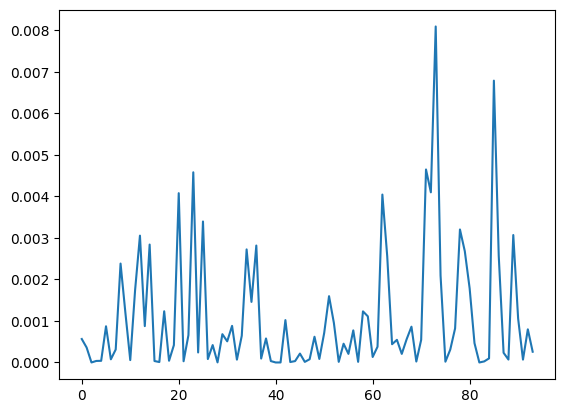

In [243]:
np.random.seed(10)
x_test = np.random.randn(100, 1)

### plot error 
import matplotlib.pyplot as plt
TestErrorRecord = []
for i in range(k//2, len(x_test)- k // 2):
    y_test = Convolution(x_test[i-k//2 : i + k//2 + 1], k, True_coefficients.flatten())
    y_hat = Convolution(x_test[i-k//2 : i + k//2 + 1], k, Estimated_coefficients)
    TestErrorRecord.append((y_test - y_hat)**2)

plt.plot(TestErrorRecord)
plt.show()

In [244]:
i = 10
print("y[i]", y[i])
print("Yi_esti", Convolution(x[i-k//2 : i + k//2 + 1], k, Estimated_coefficients))

y[i] [3.72137124]
Yi_esti [3.50528912]


### Plot the error

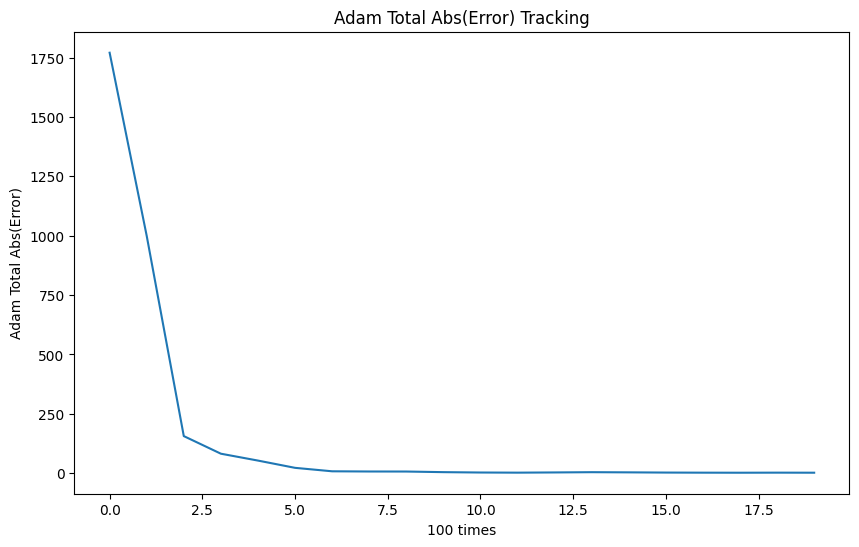

In [245]:
import matplotlib.pyplot as plt
### set fig size
plt.figure(figsize=(10, 6))
plt.plot(ErrorRecord)
plt.xlabel("100 times")
plt.ylabel("Adam Total Abs(Error)")
plt.title("Adam Total Abs(Error) Tracking")
### save the plot
plt.savefig("adam_error.png", dpi=300)

plt.show()


In [246]:
ErrorRecord[-1]

array([2.29171638])

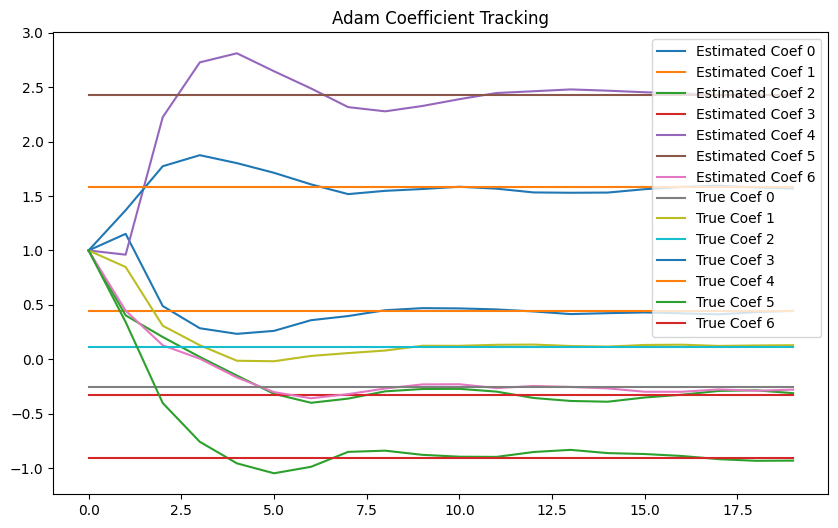

In [247]:
### Plot the Coefficient tracking plot and ground truth(each a line )
CoefRecord = np.array(CoefRecord)
### set fig size
plt.figure(figsize=(10, 6))
for i in range(k):
    plt.plot(CoefRecord[:,i])
    plt.plot(np.array([True_coefficients[i] for _ in range(len(CoefRecord))]).reshape(-1))
plt.title("Adam Coefficient Tracking")
plt.legend(["Estimated Coef %d" % i for i in range(k)] + ["True Coef %d" % i for i in range(k)])

### save the plot
plt.savefig("adam_coef.png", dpi=300)
plt.show()


In [248]:
CoefRecord[-1]

array([ 0.44533286, -0.3102558 ,  2.4311415 , -0.27799233,  0.13002365,
        1.56913362, -0.92962466])

In [249]:
w = np.ones((k))
print(w)

[1. 1. 1. 1. 1. 1. 1.]
